In [1]:
import os
import time
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import pyabf
import utils

%load_ext autoreload
%autoreload 2

In [2]:
human18_meta = pd.read_csv('./data/raw/Metadata/Human18_Metadatav2.csv')
human18_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
human18_meta.shape

(139, 18)

In [4]:
human18_meta.head()

,ABF File,Data Type,Exp. Date,Case #,Cell #,Cell Layer,Stim Type,Threshold,Gain Value,ZD,Hold,Unnamed: 12,Gain,Offset,Response Channel,Command Channel,RMP,Stimulus type
0,18320001,Human,March_20_2018,First,C1,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-20.0,Iclamp(mV),Current_in(pA),-70.0,Ramp
1,18320005,Human,March_20_2018,First,C1,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-20.0,Iclamp(mV),Current_in(pA),-70.5,Long_Square
2,18320015,Human,March_20_2018,First,C2,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-20.0,Iclamp(mV),Current_in(pA),-68.1,Long_Square
3,18320019,Human,March_20_2018,First,C3,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-27.0,Iclamp(mV),Current_in(pA),-71.3,Ramp
4,18320021,Human,March_20_2018,First,C3,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-27.0,Iclamp(mV),Current_in(pA),-71.3,Long_Square


In [5]:
human18_meta['Stim Type'].value_counts()

Gain      92
Firing    42
n.a        5
Name: Stim Type, dtype: int64

In [6]:
human18_meta['Stimulus type'].value_counts()

Long_Square    22
Ramp           20
Name: Stimulus type, dtype: int64

In [7]:
human18_meta.drop_duplicates(subset='ABF File', inplace=True)

## Identify files to be converted
- ABF files from human2018
- need metadata to determine which files are testing intrinsic properties
- extract ABF version info, time of creation and comments from the ABF file

In [8]:
human2018_abf_dir = Path("./data/raw/recordings/Human tissue/Human tissue-White noise_2018/")
human2018_file_info = utils.summary_df(human2018_abf_dir)

In [9]:
human2018_file_info.shape

(174, 2)

In [10]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

def check_protocolpath_for_experimenter(abf_path):
    abf = pyabf.ABF(abf_path)
    if 'Homeira' in abf.protocolPath:
        return 'Homeira'
    elif 'Lihua' in abf.protocolPath:
        return 'Lihua'
    else:
        #print(abf.protocolPath)
        return None

#human2018_file_info['timestamp'] = human2018_file_info.path.apply(parse_timestamp)
#human2018_file_info['abf_version'] = human2018_file_info.path.apply(extract_abf_version)
#human2018_file_info['abf_comments'] = human2018_file_info.path.apply(extract_abf_comments)
human2018_file_info['experimenter'] = human2018_file_info.path.apply(check_protocolpath_for_experimenter)

# add this column to merge with provided metadata
human2018_file_info['file_id'] = human2018_file_info.file_name.apply(lambda x: Path(x).stem) 

CPU times: user 753 ms, sys: 342 ms, total: 1.09 s
Wall time: 1.3 s


In [11]:
human2018_file_info.experimenter.value_counts()

Homeira    77
Name: experimenter, dtype: int64

In [12]:
human2018_file_info.file_id.nunique()

162

In [13]:
human2018_file_info.drop_duplicates(subset='file_id', keep='first', inplace=True)

In [14]:
human2018_file_info.shape

(162, 4)

In [15]:
merged_meta = human18_meta.merge(human2018_file_info, left_on='ABF File', right_on='file_id' , how='left').drop('ABF File', axis=1)

In [16]:
merged_meta.shape

(131, 21)

## Extract metadata required for conversion process

In [18]:
# sweep through all listed abf files and extract all relevant metadata required to parse raw data
results_list = []
for i, row in merged_meta.iterrows():
    
    resp_chan = 0
    stim_chan = 0
    stim_info_dict = {}
    
    abf = pyabf.ABF(row.path)
    num_sweeps = abf.sweepCount
    abf_tag = abf.tagComments
    if abf_tag:
        abf_tag = abf_tag[0]
    else:
        abf_tag = None
    print(row.path)
    print(abf_tag)
    
    if len(abf.channelList) == 3:
        #print(abf_file)
        stim_chan = 2
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 1
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = 10
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 
                          'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
        print(stim_dict)
        
    elif len(abf.channelList) == 4:

        stim_chan = 3
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 2
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = .2
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
    else:
        # figure out response channel
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        resp_sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)

        stim_name = 'sweepY'
        
        cell_meta_df = None
        try:
            stim_dict = utils.get_stim_dict2(row, cell_meta_df, stim_name)
        except AttributeError as e:
            print(e)
        
        # if in the odd case the number of sweeps doesn't match between resp vs stim file, then make them match
    print(f'num_sweeps: {num_sweeps}')
    print(f'stim_dict: {stim_dict}')
    if num_sweeps != stim_dict['num_sweeps']:
        #print(abf_file)
        stim_dict['num_sweeps'] = num_sweeps
        stim_dict['stim_amp_vec'] = stim_dict['stim_amp_vec'][0:num_sweeps]
        
    ret_dict = {'cell_id' : row.file_id, 'resp_chan' : resp_chan, 
                'resp_gain' : best_gain, 'rmp_error' : rmp_abs_error, 'abf_tag' : abf_tag,
                'rmp_val' : row.RMP, 'resp_offset' : row.Offset,
                'abf_version' : abf.abfVersionString, 'resp_sampling_rate' : resp_sampling_rate, 'stim_name' : stim_name, 
               'file_time' : abf.abfDateTime}
    #ret_dict = dict(ret_dict.items() + stim_info_dict.items())
    ret_dict.update(stim_dict)
    #print(ret_dict)

    results_list.append(ret_dict)
    print('--'*50)

data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/Second case/C1_L23/firing/18320001.abf
C1; L2/3; RMP --61.4;
num_sweeps: 20
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/Second case/C1_L23/firing/18320001.abf', 'valid_stim': True, 'stim_amp_vec': array([-1.,  2.,  2., ..., -1.,  0., -2.]), 'stim_duration': 0.0281, 'stim_start_time': 0.0004, 'stim_end_time': 0.2999, 'num_sweeps': 20, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/First case/C1_L23/Firing/18320005.abf
C1; L2/3; RMP -70.5; Offset 20 mv;1s;-220/40
num_sweeps: 14
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/First case/C1_L23/Firing/18320005.abf', 'valid_stim':

num_sweeps: 11
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/Feb_01_2018/C5_L5/Firing/18201028.abf', 'valid_stim': True, 'stim_amp_vec': array([-125.,  -74.,  -25., ...,  277.,  327.,  374.]), 'stim_duration': 0.2474, 'stim_start_time': 0.0373, 'stim_end_time': 1.0371000000000001, 'num_sweeps': 11, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/Feb_01_2018/C5_L5/Firing/18201029.abf
C5, RMP -66.9 mv, layer 5,
num_sweeps: 4
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/Feb_01_2018/C5_L5/Firing/18201029.abf', 'valid_stim': True, 'stim_amp_vec': array([ 1., 30., 58., 88.]), 'stim_duration': 0.0045, 'stim_start_time': 0.4827, 'stim_end_time': 0.5095000000000001, 'num_sweeps': 4, 'stim_sampling_

data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C3_L23/Firing/18o22020.abf
C3, l2/3; rmp -68.4 MV; p offset: -20mv
num_sweeps: 15
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C3_L23/Firing/18o22020.abf', 'valid_stim': True, 'stim_amp_vec': array([-597., -500., -399., ...,  602.,  700.,  802.]), 'stim_duration': 0.2339, 'stim_start_time': 0.0373, 'stim_end_time': 1.0371000000000001, 'num_sweeps': 15, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/Second case/C1_L23/Gain 20/18320006.abf
C1; L2/3; RMP --61.4; offset -20; Gain 20; DC 75
num_sweeps: 10
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/Second case/C1_L23/Gain

num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/April_17_2018/C3_L23/Gain 40/18417026.abf', 'valid_stim': False, 'stim_amp_vec': array([43., 43., 43., ..., 43., 43., 43.]), 'stim_duration': 0.0438, 'stim_start_time': 0.060200000000000004, 'stim_end_time': 2.5105, 'num_sweeps': 30, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/April_17_2018/C3_L23/Gain 40/18417030.abf
Cell 3,  RMP -64.7 L2/3; offset -17.5 mv, Gain 40; DC100
num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/April_17_2018/C3_L23/Gain 40/18417030.abf', 'valid_stim': True, 'stim_amp_vec': array([56., 56., 56., ..., 56., 55., 56.]), 'stim_duration': 0.0423, 'stim_start_time': 0.060200000000000004, 'stim_end_ti

num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/Feb_01_2018/C3_L5/Gain 40/18201019.abf', 'valid_stim': True, 'stim_amp_vec': array([130676., 130371., 130554., ..., 130371., 130676., 130554.]), 'stim_duration': 0.0044, 'stim_start_time': 0.0663, 'stim_end_time': 2.3882000000000003, 'num_sweeps': 30, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/Feb_01_2018/C3_L5/Gain 40/18201020.abf
C3, RMP -66.5 mv, layer 5, gain 40, DC 200, every 20s
num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/Feb_01_2018/C3_L5/Gain 40/18201020.abf', 'valid_stim': True, 'stim_amp_vec': array([105591., 105957., 106140., ..., 105652., 105286., 105896.]), 'stim_duration': 0.0028, 'stim_start_ti

data/raw/recordings/Human tissue/Human tissue-White noise_2018/Jan_25_2018/C3_L5/Gain 40/18125007.abf
C3, L5, RMP: -64.2mv.Gain 40, Dc 75- 1-30, every 13 s
num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/Jan_25_2018/C3_L5/Gain 40/18125007.abf', 'valid_stim': False, 'stim_amp_vec': array([43., 43., 43., ..., 43., 43., 43.]), 'stim_duration': 0.0434, 'stim_start_time': 0.060200000000000004, 'stim_end_time': 2.5107, 'num_sweeps': 30, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/Jan_25_2018/C3_L5/Gain 40/18125008.abf
C3, L5, RMP: -64.2mv.Gain 40, Dc 100- 1-30, every 13 s
num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/Jan_25_2018/C3_L5/Gain 40/18125008.abf', 'valid_stim':

num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/Jan_29_2018/C4_L5/18129016.abf', 'valid_stim': True, 'stim_amp_vec': array([28., 28., 28., ..., 28., 28., 28.]), 'stim_duration': 0.0875, 'stim_start_time': 0.060200000000000004, 'stim_end_time': 2.5299, 'num_sweeps': 30, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_29_2018/C10_L23/Gain 40/18329052.abf
C10  L2/3; RMP -61mv; -15 mv, Gain 40, DC 125
num_sweeps: 27
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_29_2018/C10_L23/Gain 40/18329052.abf', 'valid_stim': True, 'stim_amp_vec': array([81., 81., 81., ..., 81., 81., 81.]), 'stim_duration': 0.0463, 'stim_start_time': 0.060200000000000004, 'stim_end_time': 2.5299, 'num_swe

data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C3_L23/Gain 40/18o22021.abf
C3, l2/3; rmp -68.4 MV; p offset: -20mv, DC 50; Gain 40
num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C3_L23/Gain 40/18o22021.abf', 'valid_stim': True, 'stim_amp_vec': array([31., 31., 31., ..., 30., 31., 30.]), 'stim_duration': 0.0439, 'stim_start_time': 0.060200000000000004, 'stim_end_time': 2.5300000000000002, 'num_sweeps': 30, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C3_L23/Gain 40/18o22023.abf
C3, l2/3; rmp -68.4 MV; p offset: -20mv, DC75; Gain 40
num_sweeps: 30
stim_dict: {'stim_chan': 1, 'stim_gain': 1, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C3_L23

In [19]:
extracted_meta = pd.DataFrame(results_list)

In [20]:
extracted_meta.shape

(131, 21)

In [21]:
merged_meta.iloc[0]

Data Type                                                       Human
Exp. Date                                               March_20_2018
Case #                                                          First
Cell #                                                             C1
Cell Layer                                                        L23
Stim Type                                                      Firing
Threshold                                                         n.a
Gain Value                                                        n.a
ZD                                                                n.a
Hold                                                              n.a
Unnamed: 12                                                       NaN
Gain                                                              1.0
Offset                                                          -20.0
Response Channel                                           Iclamp(mV)
Command Channel     

In [22]:
extracted_meta.iloc[0]

cell_id                                                        18320001
resp_chan                                                             0
resp_gain                                                        1000.0
rmp_error                                                      3.918457
abf_tag                                           C1; L2/3; RMP --61.4;
rmp_val                                                           -70.0
resp_offset                                                       -20.0
abf_version                                                     1.8.3.0
resp_sampling_rate                                                10000
stim_name                                                        sweepY
file_time                                    2018-03-20 18:12:52.812000
stim_chan                                                             1
stim_gain                                                             1
stim_path             data/raw/recordings/Human tissue/Human tis

In [26]:
all_meta = merged_meta.merge(extracted_meta, left_on='file_id', right_on='cell_id', how='left').drop('cell_id', axis=1)

In [27]:
all_meta.iloc[0]

Data Type                                                         Human
Exp. Date                                                 March_20_2018
Case #                                                            First
Cell #                                                               C1
Cell Layer                                                          L23
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                         NaN
Gain                                                                1.0
Offset                                                            -20.0
Response Channel                                             Icl

In [28]:
# after visual QC, determined stim gains for this dataset need to be set to 400
all_meta.stim_gain = 400

In [29]:
meta_path = Path('./data/processed/meta')
meta_path.mkdir(exist_ok=True)
all_meta.to_csv(meta_path / 'h2018_meta.csv')

## Convert

In [30]:
output_dir = Path("data/processed/recordings/human2018/")
output_dir.mkdir(exist_ok=True, parents=True)

In [31]:
from x_to_nwb import ABF2Converter
from x_to_nwb import ABF1Converter

In [32]:
meta.shape

(131, 41)

In [34]:
all_meta[all_meta['Stimulus type'] == 'Long_Square']

,Data Type,Exp. Date,Case #,Cell #,Cell Layer,Stim Type,Threshold,Gain Value,ZD,Hold,...,stim_chan,stim_gain,stim_path,valid_stim,stim_amp_vec,stim_duration,stim_start_time,stim_end_time,num_sweeps,stim_sampling_rate
1,Human,March_20_2018,First,C1,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-551.0, -450.0, -353.0, -251.0, -152.0, -51.0...",0.1496,0.0374,1.0362,14,10000
2,Human,March_20_2018,First,C2,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[90210.0, 90210.0, 90515.0, 90759.0, 90454.0, ...",0.0054,0.2111,2.3917,11,10000
4,Human,March_20_2018,First,C3,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-549.0, -450.0, -349.0, -249.0, -149.0, -49.0...",0.2729,0.0373,1.0361,12,10000
7,Human,March_20_2018,Second,C2,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-548.0, -450.0, -350.0, -249.0, -148.0, -48.0...",0.3211,0.0375,1.0369,13,10000
11,Human,March_20_2018,Second,C5,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-550.0, -449.0, -349.0, -251.0, -149.0, -48.0...",0.4860,0.0372,1.0369,15,10000
14,Human,April_26_2018,n.a,C1,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-600.0, -500.0, -400.0, -302.0, -201.0, -103....",0.2952,0.0382,1.0370,13,10000
16,Human,April_26_2018,n.a,C2,L23,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-600.0, -500.0, -400.0, -299.0, -200.0, -99.0...",0.3348,0.0373,1.0371,16,10000
17,Human,Feb_01_2018,n.a,C1,L5,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-127.0, -74.0, -23.0, 26.0, 74.0, 125.0, 176....",0.3357,0.0375,1.0364,8,10000
19,Human,Feb_01_2018,n.a,C3,L5,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-124.0, -73.0, -24.0, 25.0, 74.0, 125.0, 177....",0.0847,0.0375,1.0369,13,10000
20,Human,Feb_01_2018,n.a,C5,L5,Firing,n.a,n.a,n.a,n.a,...,1,400,data/raw/recordings/Human tissue/Human tissue-...,True,"[-125.0, -74.0, -25.0, 25.0, 75.0, 126.0, 174....",0.2474,0.0373,1.0371,11,10000


In [35]:
%%time
errors = []

for i, file_info in all_meta[all_meta['Stimulus type'] == 'Long_Square'].iterrows():
    print(file_info)
    try:
        abf = pyabf.ABF(file_info.path) # abf file to be converted
        file_stem = file_info.file_id # file stem with no file type
        
        # figure out if stimulus is on dac or adc channels
        if file_info.stim_name == 'sweepC': 
            stim_chan = abf.dacNames[file_info.stim_chan] 
        else: #if stim_name is sweepY
            stim_chan = abf.adcNames[file_info.stim_chan] 
        
        resp_chan = abf.adcNames[file_info.resp_chan] # response seems always to be in adc channels
        
        # this should be populated with metadata from homeira!
        meta = {
            'Subject': {
                'age': None,
                'description': f'{file_info.abf_tag}',
                'species': 'Homo sapiens',
                'subject_id': f'Donor_'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        
        if file_info.abf_version == '2.6.0.0': # if abf v2 file
            # i didn't use gain here because none of my abf v2 files needed a gain - feel free to add one though
            nwb = ABF2Converter.ABF2Converter(file_info.path, 
                                              str(output_path), 
                                              includeChannelList=[resp_chan], 
                                              stimulus_name=stim_chan, 
                                              metadata=meta)
        
        else: # if abf 1 file
            nwb = ABF1Converter.ABF1Converter(inputPath = file_info.path, 
                                                    outputFilePath = str(output_path), 
                                                    acquisitionChannelName = resp_chan, 
                                                    stimulusChannelName = stim_chan,
                                                    metadata=meta, 
                                                    responseGain = file_info.resp_gain, # gain on response channel
                                                    stimulusGain = file_info.stim_gain, # gain on stimulus channel
                                                    responseOffset = file_info.resp_offset, # voltage offset on resp channel
                                                    )
            nwb.convert()
        print(nwb)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        print('--'*50)
        
    except (ValueError, IndexError, TypeError, KeyError, UnicodeDecodeError, AttributeError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

Data Type                                                         Human
Exp. Date                                                 March_20_2018
Case #                                                            First
Cell #                                                               C1
Cell Layer                                                          L23
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                         NaN
Gain                                                                1.0
Offset                                                            -20.0
Response Channel                                             Icl

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


Successfully converted to data/processed/recordings/human2018/18320005.nwb.
NWB Conversion complete for 18320005.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Human
Exp. Date                                                 March_20_2018
Case #                                                            First
Cell #                                                               C2
Cell Layer                                                          L23
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                  

Successfully converted to data/processed/recordings/human2018/18320014.nwb.
NWB Conversion complete for 18320014.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Human
Exp. Date                                                 March_20_2018
Case #                                                           Second
Cell #                                                               C5
Cell Layer                                                          L23
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                  

Successfully converted to data/processed/recordings/human2018/18426017.nwb.
NWB Conversion complete for 18426017.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Human
Exp. Date                                                   Feb_01_2018
Case #                                                              n.a
Cell #                                                               C1
Cell Layer                                                           L5
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                  

Successfully converted to data/processed/recordings/human2018/18201028.nwb.
NWB Conversion complete for 18201028.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Human
Exp. Date                                                   Feb_20_2018
Case #                                                              n.a
Cell #                                                               C3
Cell Layer                                                          L23
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                  

Successfully converted to data/processed/recordings/human2018/18129004.nwb.
NWB Conversion complete for 18129004.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Human
Exp. Date                                                   Jan_29_2018
Case #                                                              n.a
Cell #                                                               C3
Cell Layer                                                           L5
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                  

Successfully converted to data/processed/recordings/human2018/18329062.nwb.
NWB Conversion complete for 18329062.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Human
Exp. Date                                                 March_29_2018
Case #                                                              n.a
Cell #                                                               C3
Cell Layer                                                          L23
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                  

Successfully converted to data/processed/recordings/human2018/18o22001.nwb.
NWB Conversion complete for 18o22001.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                         Human
Exp. Date                                              October_ 22_2018
Case #                                                              n.a
Cell #                                                               C2
Cell Layer                                                          L23
Stim Type                                                        Firing
Threshold                                                           n.a
Gain Value                                                          n.a
ZD                                                                  n.a
Hold                                                                n.a
Unnamed: 12                                                  

## Plot the converted nwb files

In [31]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

In [32]:
nwb_files = utils.summary_df(path=Path('./data/processed/recordings/human2018/'), suffix='.nwb')

loading dataset into data structure...
data/processed/recordings/human2018/18129004.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18129009.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18201004.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18201011.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18201028.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18220008.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18220019.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18320005.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18320014.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18320021.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18320031.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18329014.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18329044.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18329051.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18329062.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18426010.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18426017.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18o22001.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18o22010.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/human2018/18o22020.nwb


/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


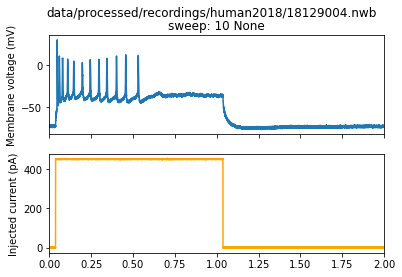

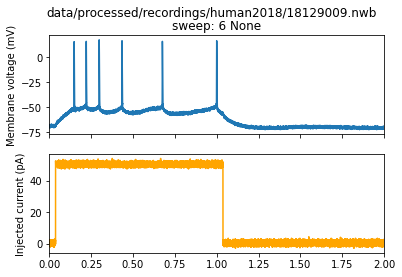

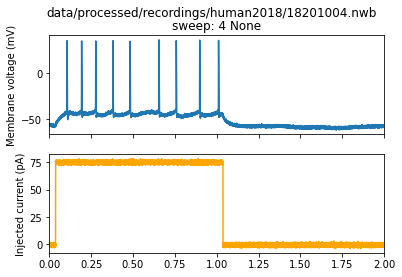

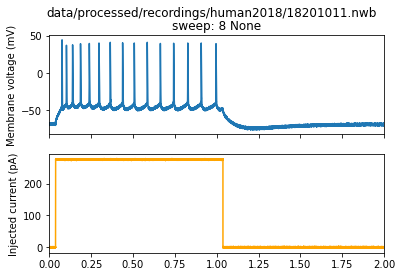

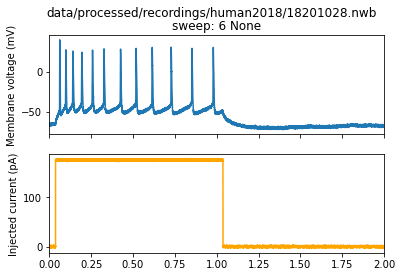

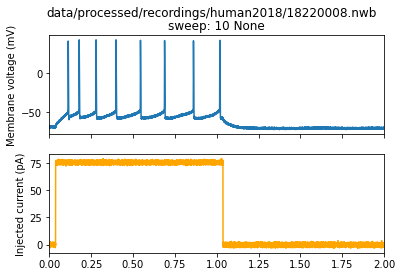

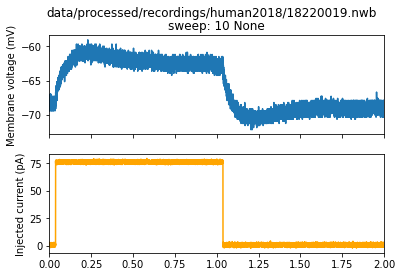

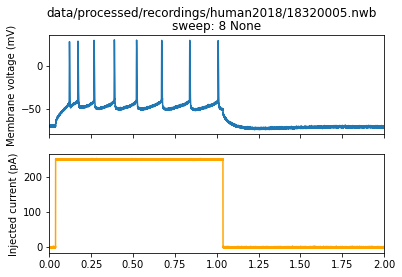

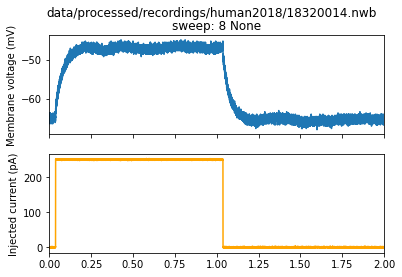

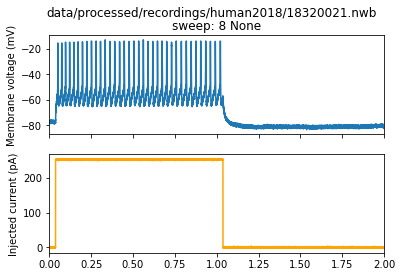

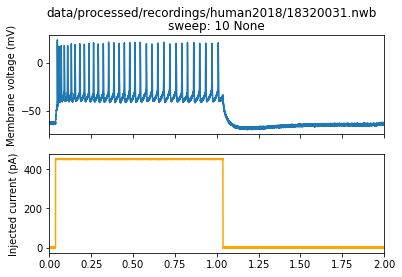

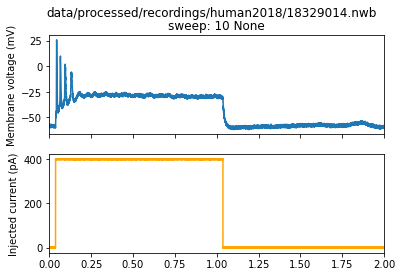

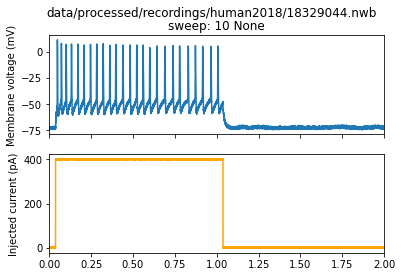

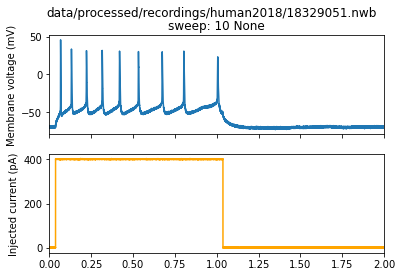

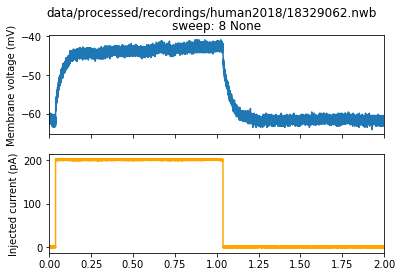

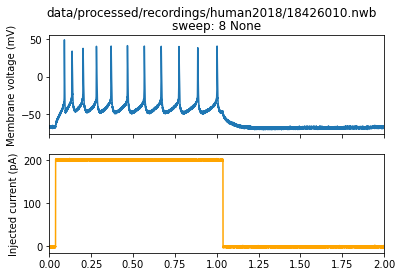

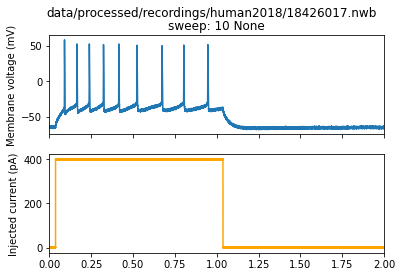

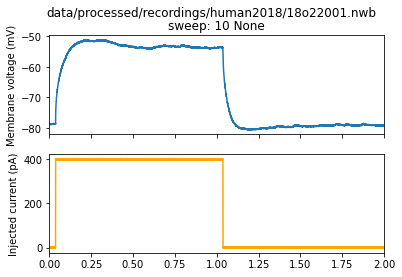

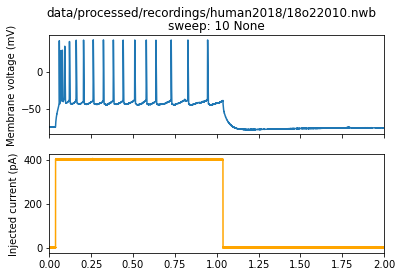

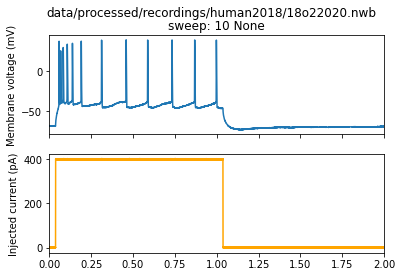

In [33]:
for i, row in nwb_files.sort_values('file_name').iterrows():
    utils.plot_nwb_sweep(file_name=row.path, ontology=ontology_path)

In [1]:
!dandi validate ./data/processed/recordings/human2018/

2021-10-19 17:47:39,205 [    INFO] ./data/processed/recordings/human2018/18329051.nwb: ok
2021-10-19 17:47:41,849 [    INFO] ./data/processed/recordings/human2018/18329044.nwb: ok
2021-10-19 17:47:44,272 [    INFO] ./data/processed/recordings/human2018/18o22020.nwb: ok
2021-10-19 17:47:46,760 [    INFO] ./data/processed/recordings/human2018/18129004.nwb: ok
2021-10-19 17:47:49,065 [    INFO] ./data/processed/recordings/human2018/18320014.nwb: ok
2021-10-19 17:47:51,299 [    INFO] ./data/processed/recordings/human2018/18426010.nwb: ok
2021-10-19 17:47:53,756 [    INFO] ./data/processed/recordings/human2018/18320005.nwb: ok
2021-10-19 17:47:56,198 [    INFO] ./data/processed/recordings/human2018/18426017.nwb: ok
2021-10-19 17:47:58,576 [    INFO] ./data/processed/recordings/human2018/18201011.nwb: ok
2021-10-19 17:48:00,858 [    INFO] ./data/processed/recordings/human2018/18220008.nwb: ok
2021-10-19 17:48:03,054 [    INFO] ./data/processed/recordings/human2018/18320021.nwb: ok
2021-10-19